In [162]:
from filtros import *
from fit_voc import *

In [163]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm

# Vemos datos de descarga en vehículos reales

In [164]:
df = pd.read_parquet(os.path.join('data_ejemplos', 'Data_vehiculo', 'Smart-1_field_capacity.parquet'))
print('Nivel de degradación: ', 100-min(df.Capacity.values)/max(df.Capacity.values)*100, '%')
df

Nivel de degradación:  11.779980675969753 %


,time_num,Speed,Odometer,Temp_Ambient,SoC_Real,Current,Voltage,Power,Capacity,Trip,delta_time
0,735654.680961,0.0,607.0,13.5,85.8,-4.4,372.0,-1636.8,47.550375,0,0.000000
1,735654.680984,0.0,607.0,13.5,85.8,-4.6,372.0,-1711.2,47.550375,0,2.314814
2,735654.680995,0.0,607.0,13.5,85.8,-4.3,372.0,-1599.6,47.550375,0,1.157413
3,735654.681007,0.0,607.0,13.5,85.8,-4.6,372.0,-1711.2,47.550375,0,1.157401
4,735654.681019,0.0,607.0,13.5,85.8,-4.2,372.0,-1562.4,47.550375,0,1.157413
...,...,...,...,...,...,...,...,...,...,...,...
1516638,736317.669444,40.0,24599.0,11.0,91.3,18.0,382.0,6876.0,41.949002,333,1.157413
1516639,736317.669456,26.0,24599.0,11.0,91.3,3.2,378.0,1209.6,41.948989,333,1.157401
1516640,736317.669468,23.0,24599.0,11.0,91.3,-0.9,376.0,-338.4,41.948976,333,1.157413
1516641,736317.669479,20.0,24599.0,11.0,91.3,-26.6,372.0,-9895.2,41.948963,333,1.157401


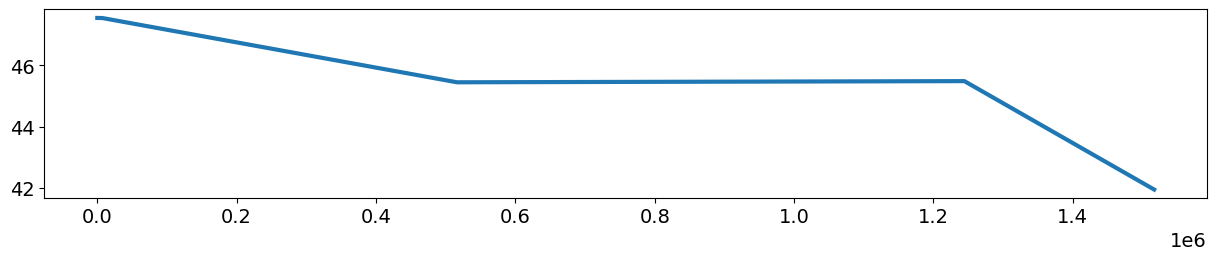

In [165]:
plt.figure(figsize = (15,2.5))
plt.plot(df.Capacity.values)
plt.show()

In [166]:
print(100- max(df.Capacity.values)/min(df.Capacity.values)*100)

-13.35295635416054


time_num            0
Speed               0
Odometer            0
Temp_Ambient    23832
SoC_Real         6814
Current            46
Voltage            46
Power              46
Capacity            0
Trip                0
delta_time          0
dtype: int64
time_num        0
Speed           0
Odometer        0
Temp_Ambient    0
SoC_Real        0
Current         0
Voltage         0
Power           0
Capacity        0
Trip            0
delta_time      0
dtype: int64


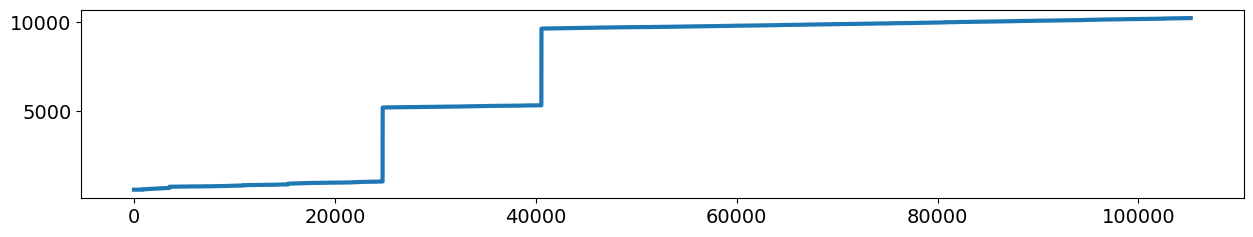

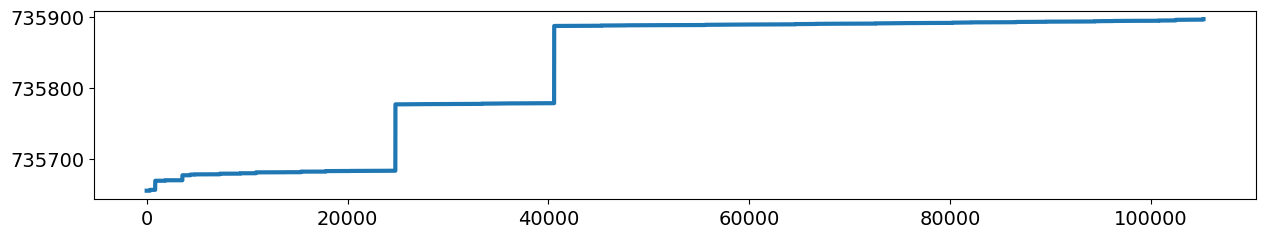

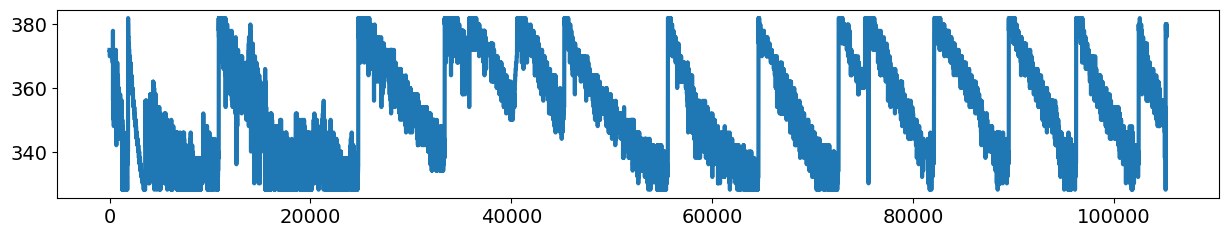

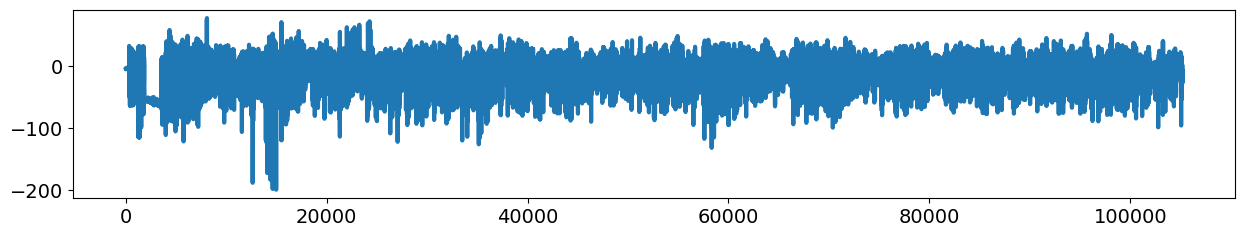

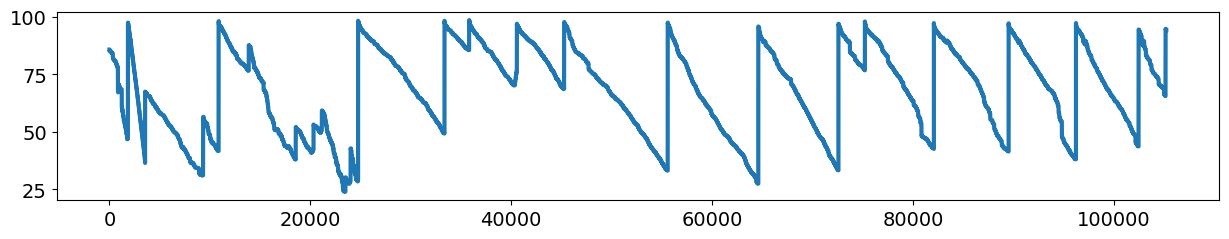

In [167]:
# Usamos los primeros 20 viajes para fittear el modelo
df_ = df[df.Trip.isin([i for i in range(20)])]
print(df_.isna().sum())
df_ = df_.dropna()
print(df_.isna().sum())

# Filtramos lso puntos de voltaje que pueden ser outliers por voltaje
f_up = df_.Voltage.quantile(0.98)
f_low = df_.Voltage.quantile(0.02)

df_ = df_[df_.Voltage < f_up]
df_ = df_[f_low < df_.Voltage]



# Ploteamos
plt.figure(figsize = (15,2.5))
plt.plot(df_.Odometer.values)
plt.show()

plt.figure(figsize = (15,2.5))
plt.plot(df_.time_num.values)
plt.show()

plt.figure(figsize = (15,2.5))
plt.plot(df_.Voltage.values)
plt.show()

plt.figure(figsize = (15,2.5))
plt.plot(df_.Current.values)
plt.show()

plt.figure(figsize = (15,2.5))
plt.plot(df_.SoC_Real.values)
plt.show()

In [168]:
# Usamos la primera descarga para un fit de PSO
V = df_.Voltage.values
I = df_.Current.values
SoC = df_.SoC_Real.values/100


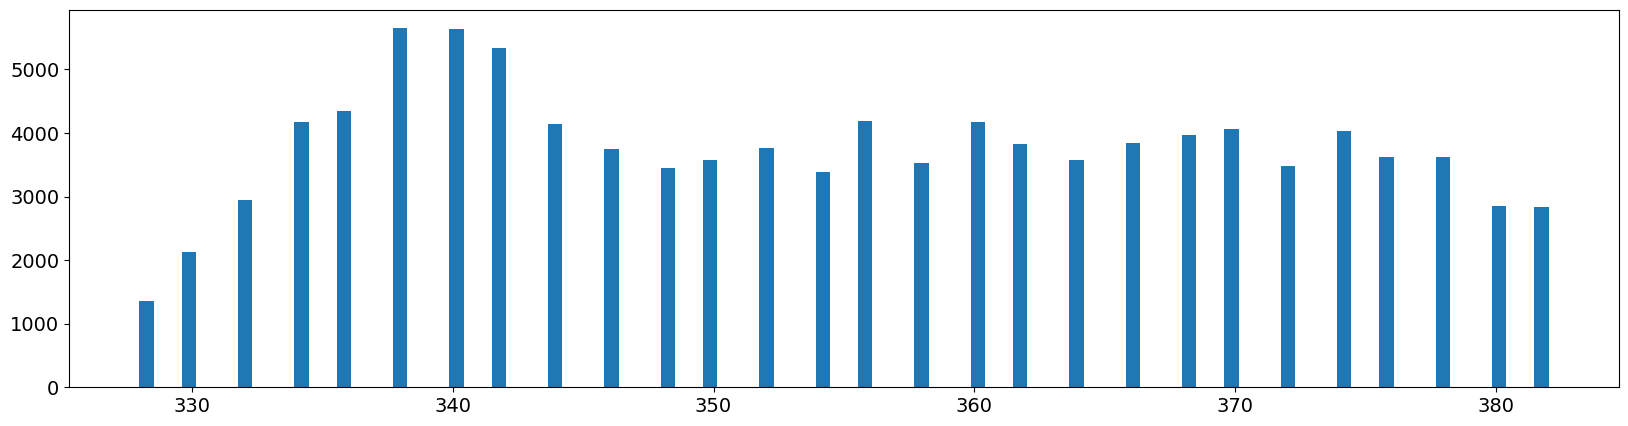

Valores distintos de V:  28
[328. 330. 332. 334. 336. 338. 340. 342. 344. 346. 348. 350. 352. 354.
 356. 358. 360. 362. 364. 366. 368. 370. 372. 374. 376. 378. 380. 382.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2.]


In [169]:
# Veamos la cuantización de V
plt.figure(figsize=(20,5))
plt.hist(V, bins = 100)
plt.show()

v_unic = np.unique(V)
delta_v = v_unic[1:] - v_unic[:-1] 
print('Valores distintos de V: ', len(np.unique(V)))
print(v_unic)
print(delta_v)

Stopping search: maximum iterations reached --> 150


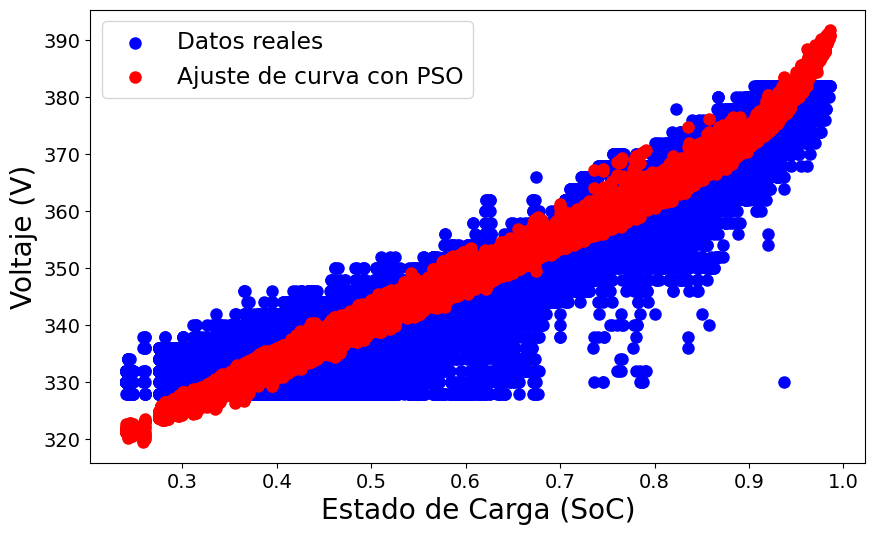

{'Parámetros optimizados': array([3.76530112e+02, 3.93863451e+02, 1.65112000e+01, 1.92610027e-01,
       3.64634805e+03, 4.80000012e-02]), 'Error Cuadrático Medio': 22.866882117234578}
Stopping search: maximum iterations reached --> 150


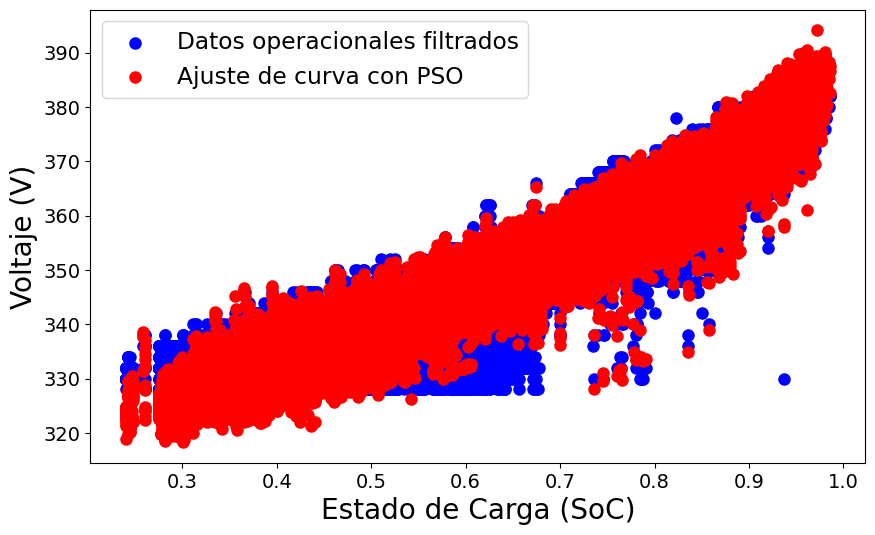

{'Parámetros optimizados': array([3.77061958e+02, 3.99784388e+02, 1.53131459e+01, 1.85185672e-01,
       2.61077522e+03, 1.46880654e+00, 4.15642852e-02]), 'Error Cuadrático Medio': 5.793130417117246}


In [170]:
# Generamos los parámetros del modelo mediante la optimización
opts = {'swarmsize': 200, 'maxiter': 150, 'minstep': 1e-10, 'minfunc': 1e-8}

param_ini = [396.654,394.896,20.639,0.161,3770.184,0.060]
lims = ([p*0.8 for p in param_ini], [p*1.2 for p in param_ini])
# print(lims)
# r:  V_L, V_0, Gamma, Alpha, Beta, R
r = optimizar_con_pso(I, V, SoC, limites=lims, parametros_iniciales = param_ini, opts = opts)
print(r)

# r: V_L, V_0, Gamma, Alpha, Beta, factor, bias
r2 = optimizar_con_pso_operacional_esc(I,V,SoC,r['Parámetros optimizados'],0.5,1.5 ,opts  )

print(r2)

In [171]:
# Instanciamos un estimador con los parámetros detectados
f_cuant = FiltrosAnidadosCuant()

param = dict(
        vL=r2['Parámetros optimizados'][0],
        v0=r2['Parámetros optimizados'][1],
        gamma=r2['Parámetros optimizados'][2],
        alpha=r2['Parámetros optimizados'][3],
        beta=r2['Parámetros optimizados'][4],
        Factor_Rint=r2['Parámetros optimizados'][5],
        Bias_Rint=r2['Parámetros optimizados'][6],
        Qmax=1,
        life_cycles=300,
    )

# f_cuant.Q_inst = param.get("Qmax")
f_cuant.fit_batt_model(param)
f_cuant.modelo_th.setup_cunti(28,328,388)



Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.04156428521307312,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 1.4688065446815757,
 'Qmax': 1,
 'alpha': 0.18518567220045556,
 'beta': 2610.7752236689544,
 'degradation_data': {'100-0': [1.0, 1.0, 1.0],
                      '100-25': [1.000003, 1.00000266, 1.00000193],
                      '100-50': [0.999989, 0.99999203, 0.9999942],
                      '100-75': [1.000027, 1.00002146, 1.00001563],
                      '25-0': [1.000054, 1.00004184, 1.00003047],
                      '50-0': [1.000037, 1.00002874, 1.00002093],
                      '50-25': [1.000043, 1.00003347, 1.00002438],
                      '62.5-37.5': [1.000008, 1.0000062, 1.00000451],
                      '75-0': [1.000024, 1.0000186, 1.00001354],
                      '75-25': 

In [172]:
print(f_cuant.modelo_th.encoder.bin_edges_[0])
print(v_unic)
f_cuant.modelo_th.encoder.bin_edges_ = [v_unic]

[328.         330.14285714 332.28571429 334.42857143 336.57142857
 338.71428571 340.85714286 343.         345.14285714 347.28571429
 349.42857143 351.57142857 353.71428571 355.85714286 358.
 360.14285714 362.28571429 364.42857143 366.57142857 368.71428571
 370.85714286 373.         375.14285714 377.28571429 379.42857143
 381.57142857 383.71428571 385.85714286 388.        ]
[328. 330. 332. 334. 336. 338. 340. 342. 344. 346. 348. 350. 352. 354.
 356. 358. 360. 362. 364. 366. 368. 370. 372. 374. 376. 378. 380. 382.]


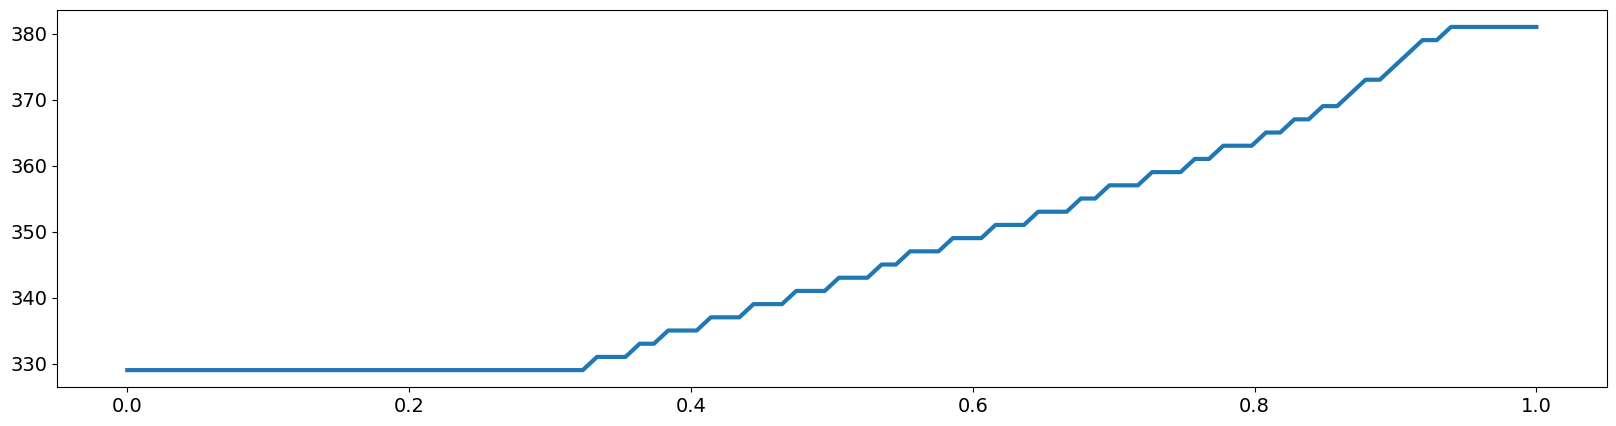

In [173]:
soc = np.linspace(0,1,100)
voc = f_cuant.modelo_th.voc(soc)

plt.figure(figsize=(20,5))
plt.plot(soc, voc)

# Usamos los filtros cuantizados

In [174]:
# Interpolamos datos en las columnas que nos interesan con el fin de eliminar nans
cols = ['SoC_Real','Current','Voltage']
print(df[cols].isna().sum())
for c in cols:
    df[c] = df[c].interpolate()
print(df[cols].isna().sum())

SoC_Real    69605
Current      1293
Voltage      1293
dtype: int64
SoC_Real    0
Current     0
Voltage     0
dtype: int64


In [175]:
lista_c = [abs(c) for c in df.Current.unique()]
lista_c.sort()
print(lista_c)

[0.0, 0.0065527065527065855, 0.013105413105413171, 0.019658119658119755, 0.020000000000000018, 0.026210826210826342, 0.02941176470588236, 0.03276353276353293, 0.03931623931623951, 0.03999999999999998, 0.0458689458689461, 0.05000000000001137, 0.052421652421652684, 0.05555555555555558, 0.05882352941176472, 0.05897435897435927, 0.05909090909090702, 0.06, 0.06552706552706586, 0.07142857142857145, 0.07207977207977244, 0.07499999999999811, 0.07777777777778283, 0.07863247863247902, 0.08000000000000002, 0.08518518518518561, 0.08823529411764708, 0.0917378917378922, 0.09829059829059879, 0.09999999999999998, 0.10000000000002274, 0.10000000000002274, 0.10484330484330537, 0.11111111111111116, 0.11139601139601195, 0.11739130434784784, 0.11764705882352944, 0.11794871794871854, 0.11818181818181404, 0.12, 0.12450142450142512, 0.125, 0.13105413105413172, 0.13125000000000142, 0.13478260869567293, 0.13760683760683828, 0.14, 0.1428571428571429, 0.14415954415954488, 0.1470588235294118, 0.14999999999999622, 

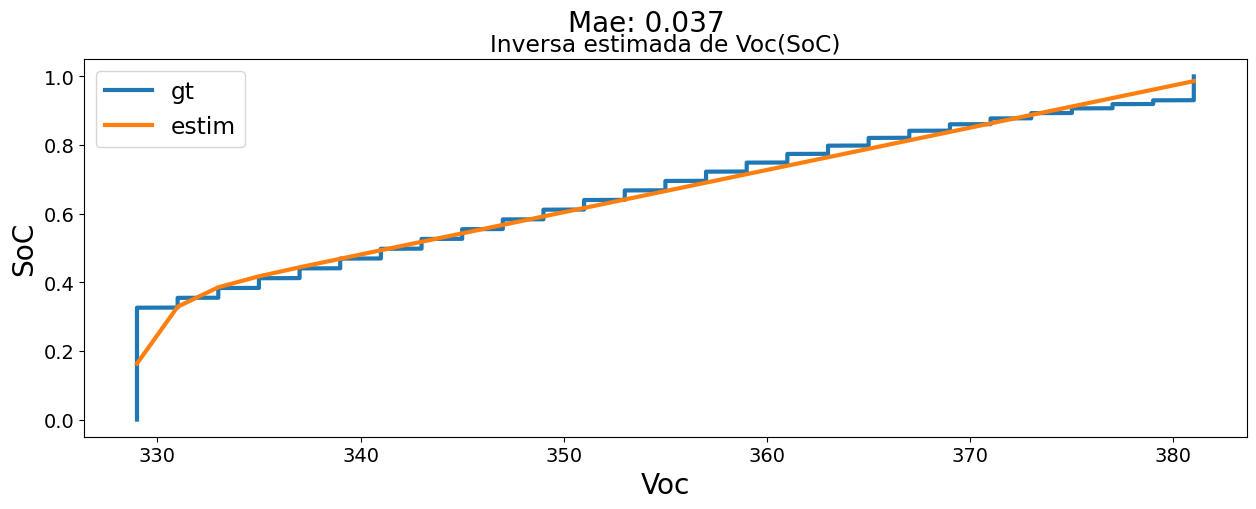

In [176]:
f_cuant.modelo_th.fit_inverse(True)

In [183]:
# Ajustamos los parámetros del estimaodor
q_healthy = df.Capacity.values[0]
print('Capacidad inicial: ', q_healthy)

f_cuant.voc_thresh = 2
f_cuant.voc_times = 45 # 60 segundos con smpleo de 1.2

# f_cuant.sigma_autonomia = 0.04
f_cuant.sigma_capacidad = 0.0025 * q_healthy
f_cuant.estim_kwargs = {"sigma_e": 1}

f_cuant.Q_inst = q_healthy

q_std = 0.001*q_healthy

Capacidad inicial:  47.55037500416766


In [184]:
# Generamos las partículas
N = 50
# particulas_soc = np.random.uniform(0.2, 1, N)
# pesos_soc = np.ones(N) / N

particulas_q = np.random.uniform(47, 48, N)
pesos_q = np.ones(N) / N

# Valor se SoC acumulado. Nos dirá cuándo se cumple un ciclo equivalente
soc_acc = 0

points_f = []
estimaciones_q = []
soc_filt = []
factores_q = []

In [185]:
estimaciones= []
gt = []

In [186]:
# Iteramos por todos los viajes
for trip in tqdm(df.Trip.unique()):#[10:]:
    df_ = df[df.Trip == trip]
    for v,c,c_,soc,soc_,dt,cap_gt in zip(
        df_.Voltage.values[1:],
        df_.Current.values[1:],
        df_.Current.values[:-1],
        df_.SoC_Real.values[1:],
        df_.SoC_Real.values[:-1],
        df_.delta_time.values[1:],
        df_.Capacity.values[1:]
        ):
        v = np.clip(v, 330,380)
        
        _ = f_cuant.detect_iterest_points(v, c, dt, False)
        soc_filt.append(soc/100)
        soc_acc += abs(soc-soc_)/100 if c < 0 else 0
        # print(soc_acc, end = '\r')

        if 1 <= soc_acc:
            if len(factores_q) != 0:

                # q_estim = np.sum(factores_q / sum(factores_q) * estimaciones_q)
                q_estim = estimaciones_q[np.argmax(factores_q)]
                q_estim_ = np.clip(q_estim, 0, q_healthy)

                # Obtenemos el modelo filtrado
                particulas_q, pesos_q, capacidad_ponderada = f_cuant.filtrar_q(
                    particulas_q, pesos_q, soc_filt, q_estim_, q_std
                )

                # print('\n',capacidad_ponderada/q_healthy*100)
                estimaciones.append(capacidad_ponderada)
                gt.append(cap_gt)
                soc_acc = 0
                # print('\n')
                # 1/0
        
    if not f_cuant.detected_points is None:
        if 60 < len(f_cuant.detected_points):
            estimaciones_q.append(f_cuant.estimate_ML((38, 52), log=True))
            factores_q.append(len(f_cuant.detected_points))
            f_cuant.reset_detector([1,1])

        




100%|██████████| 334/334 [01:56<00:00,  2.86it/s]


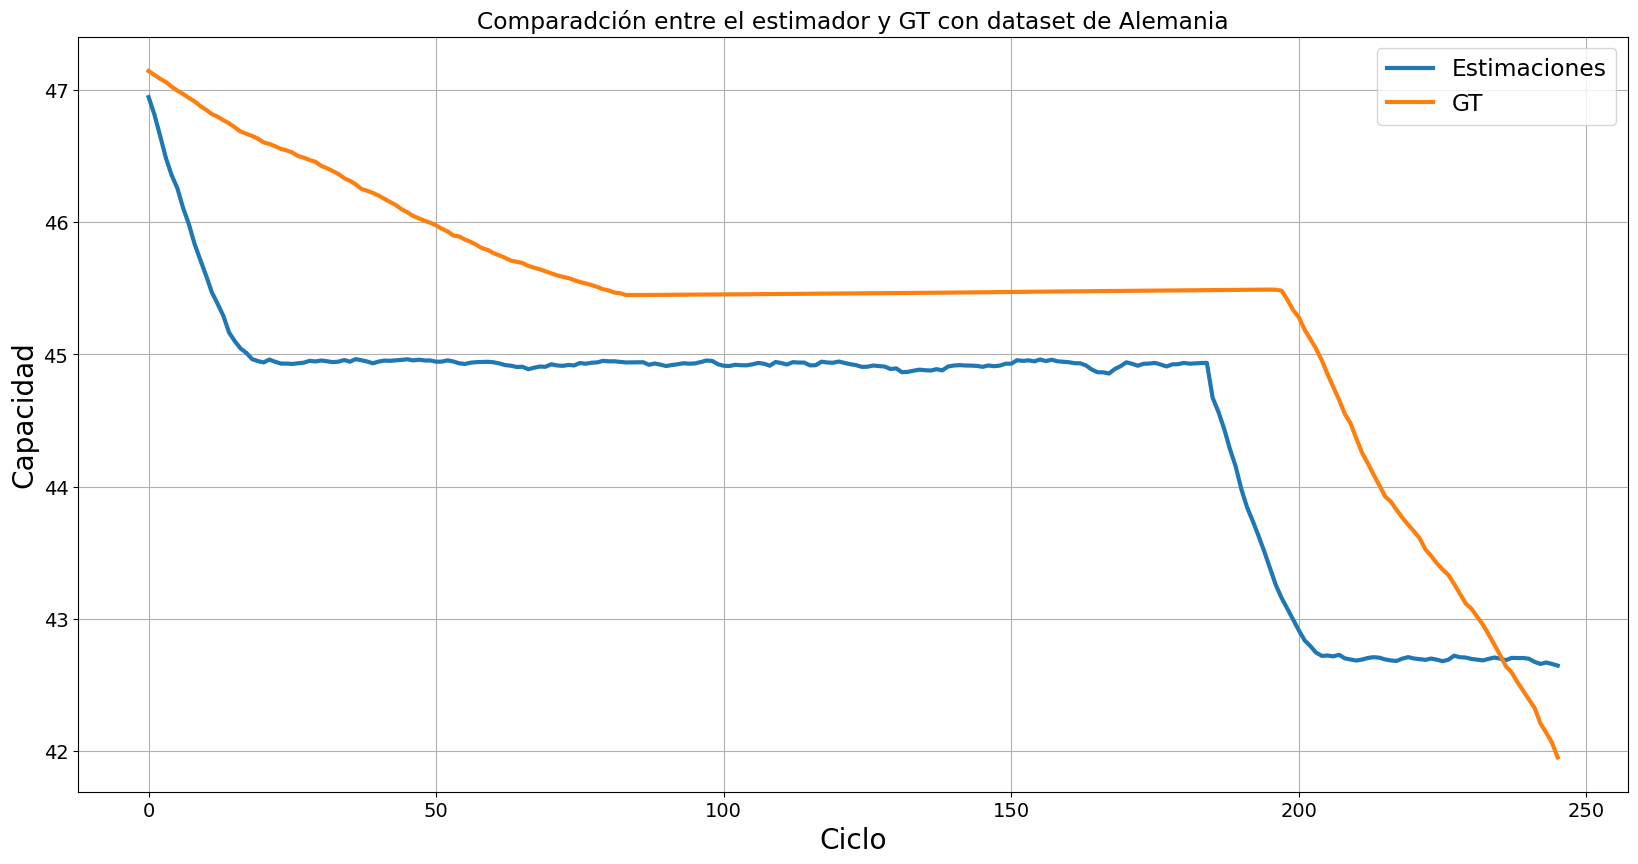

In [191]:
plt.figure(figsize=(20,10))
plt.title('Comparadción entre el estimador y GT con dataset de Alemania')
plt.plot(estimaciones, label = 'Estimaciones')
plt.plot(gt, label = 'GT')
plt.xlabel('Ciclo')
plt.ylabel('Capacidad')
plt.legend()
plt.grid(True)
plt.show()

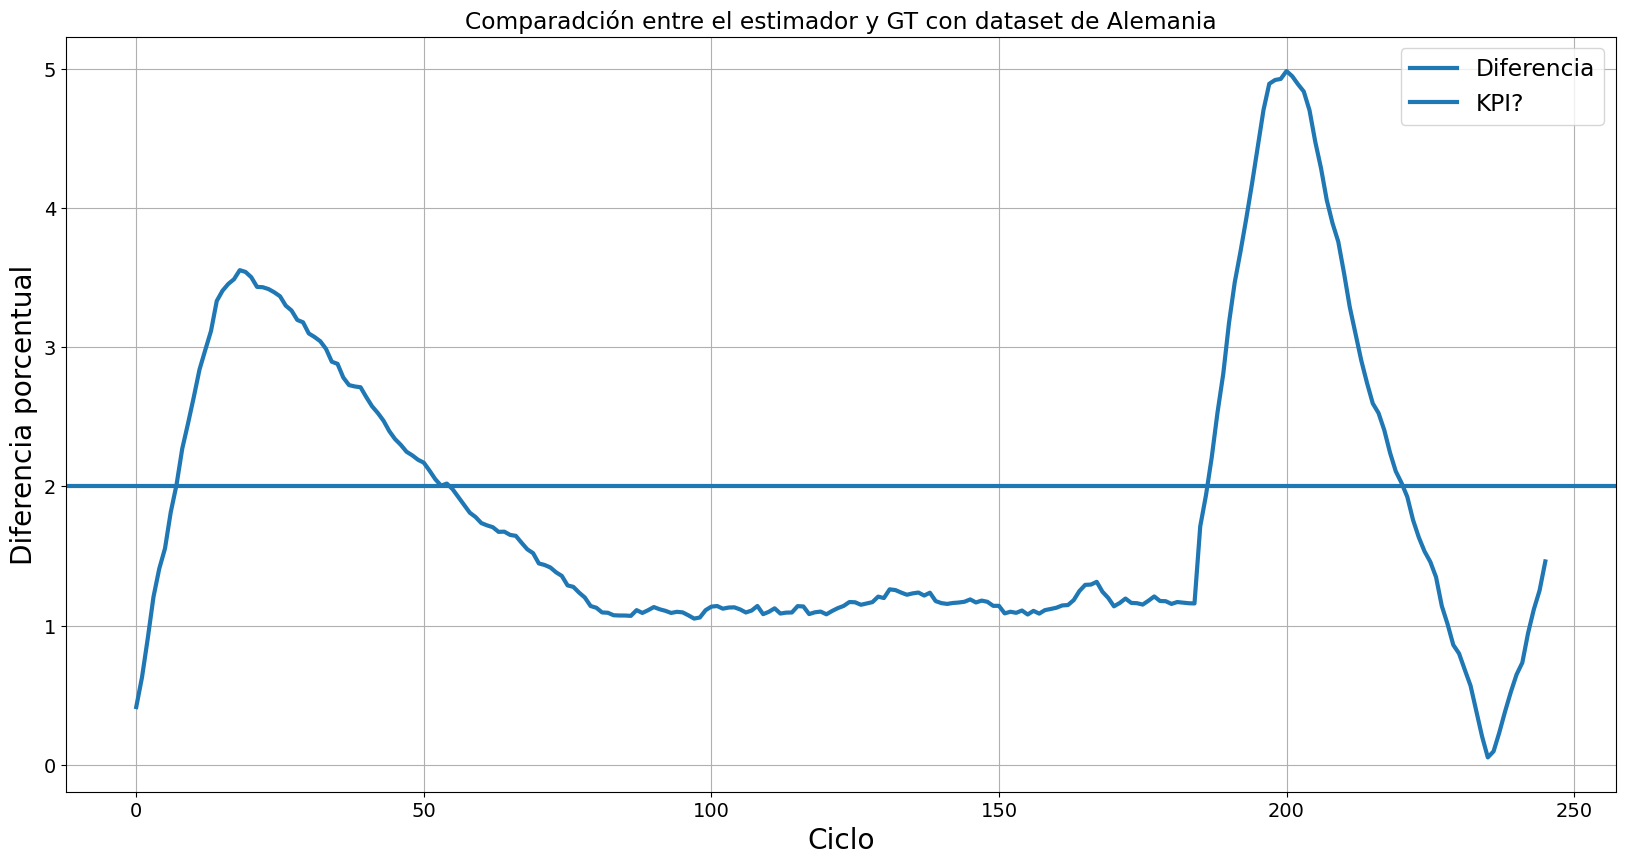

In [195]:
plt.figure(figsize=(20,10))
plt.title('Comparadción entre el estimador y GT con dataset de Alemania')
plt.plot(abs(np.array(estimaciones)-np.array(gt))/q_healthy*100, label = 'Diferencia')
plt.axhline(2, label = 'KPI?')
plt.xlabel('Ciclo')
plt.ylabel('Diferencia porcentual')
plt.legend()
plt.grid(True)
plt.show()